# First thing we will do is to build the visualization for the snakes and ladder

We will be using pygame

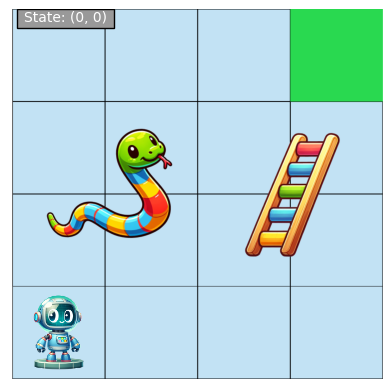

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches

def render_game_board(board_position):
    # Load and display the game board
    board_img = mpimg.imread('Snakes_and_ladder.png')
    # Path to the robot icon image
    robot_icon_path = 'robot.png'

    fig, ax = plt.subplots()
    ax.imshow(board_img)

    # Grid size and cell size calculation
    grid_size = (4, 4)  # 4x4 grid
    cell_size_x = board_img.shape[1] / grid_size[1]
    cell_size_y = board_img.shape[0] / grid_size[0]

    # Calculate robot icon position (assuming bottom left is (0,0))
    robot_x = board_position[0] * cell_size_x + cell_size_x / 2
    robot_y = (grid_size[1] - board_position[1] - 1) * cell_size_y + cell_size_y / 2

    # Load and overlay the robot icon
    robot_icon = mpimg.imread(robot_icon_path)
    zoom_factor = 0.4  # Adjust zoom factor to fit the icon in the cell
    robot_imagebox = OffsetImage(robot_icon, zoom=zoom_factor)
    robot_ab = AnnotationBbox(robot_imagebox, (robot_x, robot_y), frameon=False)
    ax.add_artist(robot_ab)

    # Add a caption indicating the current state, action, and reward
    caption_x = 10
    caption_y = 0 #board_img.shape[0] - 70
    rect = patches.Rectangle((caption_x, caption_y), 210, 40, facecolor="#999999", edgecolor="#000000")
    ax.add_patch(rect)
    plt.text(caption_x + 15, caption_y + 25, f"State: {board_position}", fontsize=10, color="white")

    plt.axis('off')  # Turn off axis
    plt.show()

# Render the board with the robot at position (0,0)
render_game_board((0, 0))



Let's create a function to define reward

In [ ]:
def get_next_position_reward(board_position,action):
  # Define the grid size and special positions
  grid_size = (4,4) #4x4 grib
  ladder_bottom = (2,1)
  ladder_top = (3,2)
  snake_head = (1,2)
  snake_tail = (0,1)


  # Set of possible actions
  action_space = {
      0:(-1,0), # Move left
      1:(1,0), # Move right
      2:(0,1), # Move up
      3:(0,-1), # Move down
  }

  # calculate the new position
  new_position = (board_position[0]+action_space[action][0],
                  board_position[1]+action_space[action][1])

  # ensure the new_position is within the board boundry
  new_position = (max(0, min(new_position[0], grid_size[0] - 1)),
                max(0, min(new_position[1], grid_size[1] - 1)))


  # Check for the special positions near the ladder and the snakes
  if new_position == ladder_bottom:
    new_position = ladder_top
    reward = 2 # Positive reward for finding the ladder
  elif new_position == snake_head:
    new_position = snake_tail
    reward = -2 # Negative reward for hitting the snake
  elif new_position == (grid_size[0]-1, grid_size[1]-1):
    reward = 5
  else:
    reward = -1 # standard step cost

  return new_position, reward



In [ ]:
next_position, reward = get_next_position_reward((1, 0), 1)  # Example: Moving right from (0,0)
print(f"Next Position: {next_position}, Reward: {reward}")

Next Position: (2, 0), Reward: -1


Let's see this in action as we randomly select from 4 actions

In [ ]:
import random
from IPython import display
import time

pos = (0,0)
total_reward = 0
for i in range(30):

  # render the board first
  render_game_board(pos)
  time.sleep(0.5)

  if pos == (3,3):
    break

  # action is randomly picked
  action = random.randint(0,3)

  # get next position and reward
  next_position, reward = get_next_position_reward(pos,action)

  display.clear_output(wait=True)

  # Update the position and the reward
  pos = next_position
  total_reward += reward


print(f"Total reward is:  {total_reward}")





Total reward is:  -21


We are now going to create a Q-table. Remember there are 4*4 = 16 board positions or 16 states. We also have 4 different actions that we can choose from i.e. (0: 'move left', 1:'move right', 2: 'move up', 3:'move down').

We use start = (0,0) to refer to bottom right and finish = (3,3) to refer to the end point. The goal for this reinforcement learning algorithm is for the agent to figure out shortest path to the finish line.


This is how we track the value

| Grid State | Action | Q-Value |
| :--- | :--- | :--- |
| (1,1) | Left | 4 |
| (1,1) | Right | 3 |
| (1,1) | Up | 4 |
| (1,1) | Down | 3 |


Now, we need to implement the *Q-learning* algorithm. Here are basically, the steps we take

  1. Pick an action to execute from the current state. We will use greedy policy. Meaning we will pick the action with the largest Q-value. If Q-values are the same, pick the action at random.
  2. Perform the action. Observe the reward and the next state from playing the game.
  3. Update the Q-value based on the Bellman equation.
    - If there is no entry in the table for the current sate,action pairs, add those entries and set the Q-values to 0.
    - Update Q-value for the current grid state and action pair. Add the observed reward plus maximum of the Q-value for the next grid state.
    - Update the grid cell to the next and repeat



In [ ]:
# Initialize an empty Q-table
Q={}

# Initialize the starting state
pos= (0,0)

# Initialize the Q-value for the starting state at 0
Q[(pos,0)] = 0 # state= (0,0) action= 0:"move left"
Q[(pos,1)] = 0 # state= (0,0) action= 1: "move right"
Q[(pos,2)] = 0 # state= (0,0) action= 2: "move up"
Q[(pos,3)] = 0 # state= (0,0) action= 1: "move down"

In [ ]:
Q

{((0, 0), 0): 0, ((0, 0), 1): 0, ((0, 0), 2): 0, ((0, 0), 3): 0}

We will define a helper function that given a state and Q table picks the action with the highest Q-value. If the Q-values are the same, it basically picks the action at random.

In [ ]:
def choose_best_action(Q, state):
    """
    Choose the action with the highest Q-value for a given state.
    If multiple actions have the same highest Q-value, one of them is chosen randomly.

    Args:
    Q (dict): Q-table where keys are (state, action) pairs, and values are Q-values.
    state (tuple): The current state (grid position).

    Returns:
    int: The action with the highest Q-value.
    """
    # Filter the Q-table to only include entries for the given state
    filtered_Q = {action: Q_value for (s, action), Q_value in Q.items() if s == state}

    # Find the maximum Q-value among these actions
    if filtered_Q != {}:
      max_Q_value = max(filtered_Q.values())
      # Get all actions that have the maximum Q-value
      best_actions = [action for action, Q_value in filtered_Q.items() if Q_value == max_Q_value]
    else:
      best_actions = [0,1,2,3]
    # Choose one of the best actions randomly
    return random.choice(best_actions)

In [ ]:
choose_best_action(Q, (0,0))

2

Now let's start making our agent play the game and update Q-value using *Q-learning* algorithm.

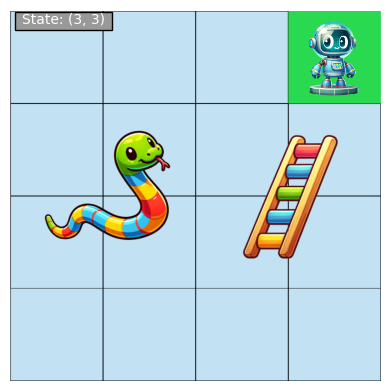

Total reward: 5


In [ ]:
# Loop over 10 game runs
# Each game ends when the agent reaches the green cell

max_num_games = 10
episodes = 0
total_reward = 0

while episodes< max_num_games:
  print(f"Current episode: {episodes}")
  time.sleep(0.5)

  # Render the current grid state
  display.clear_output(wait=True)
  render_game_board(pos)

  # If we reach the green cell reinitialize
  if pos == (3,3):
    print(f"Total reward: {total_reward}")
    time.sleep(2)
    episodes += 1
    pos = (0,0)
    total_reward = 0

  # Select an action
  action=choose_best_action(Q,pos)

  # Observe the next position and the reward
  next_pos, reward = get_next_position_reward(pos,action)

  # Add new position to the Q-table if not already
  if (next_pos, 0) not in Q:
    Q[(next_pos,0)] = 0
    Q[(next_pos,1)] = 0
    Q[(next_pos,2)] = 0
    Q[(next_pos,3)] = 0

  # Finally, update the Q-table for the current position
  Qmax = max(Q[(next_pos, 0)],
             Q[(next_pos, 1)],
             Q[(next_pos, 2)],
             Q[(next_pos, 3)])
  # add the reward
  Q[(pos, action)] = reward + Qmax

  # total reward
  total_reward += reward

  # Update to the next position
  pos = next_pos




In [ ]:
Q

{((0, 0), 0): 0, ((0, 0), 1): 0, ((0, 0), 2): 0, ((0, 0), 3): 0}

In [ ]:
def print_optimal_trajectory(Q, pos, path=None):
    if path is None:
        path = [pos]

    if pos == (3, 3):
        print("End")
        return path
    else:
        action = choose_best_action(Q, pos)
        next_pos, _ = get_next_position_reward(pos, action)
        print(str(pos) + "->" + str(next_pos))
        path.append(next_pos)
        return print_optimal_trajectory(Q, next_pos, path)

# Example usage
path = print_optimal_trajectory(Q, (0, 0))
print("Optimal Path:", path)


(0, 0)->(1, 0)
(1, 0)->(1, 1)
(1, 1)->(3, 2)
(3, 2)->(3, 3)
End
Optimal Path: [(0, 0), (1, 0), (1, 1), (3, 2), (3, 3)]


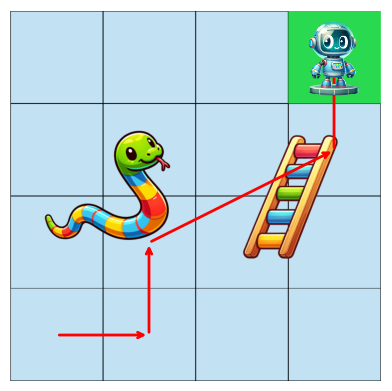

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches

def render_game_board_with_path(board_position, path):
    # Load and display the game board
    board_img = mpimg.imread('Snakes_and_ladder.png')
    # Path to the robot icon image
    robot_icon_path = 'robot.png'

    fig, ax = plt.subplots()
    ax.imshow(board_img)

    # Grid size and cell size calculation
    grid_size = (4, 4)  # 4x4 grid
    cell_size_x = board_img.shape[1] / grid_size[1]
    cell_size_y = board_img.shape[0] / grid_size[0]

    # Plot the path
    for i in range(len(path) - 1):
        start = path[i]
        end = path[i + 1]
        start_x = start[0] * cell_size_x + cell_size_x / 2
        start_y = (grid_size[1] - start[1] - 1) * cell_size_y + cell_size_y / 2
        end_x = end[0] * cell_size_x + cell_size_x / 2
        end_y = (grid_size[1] - end[1] - 1) * cell_size_y + cell_size_y / 2
        ax.annotate("", xy=(end_x, end_y), xytext=(start_x, start_y),
                    arrowprops=dict(arrowstyle="->", lw=2, color="red"))

    # Load and overlay the robot icon at the last position
    robot_icon = mpimg.imread(robot_icon_path)
    zoom_factor = 0.4  # Adjust zoom factor to fit the icon in the cell
    robot_imagebox = OffsetImage(robot_icon, zoom=zoom_factor)
    robot_x = board_position[0] * cell_size_x + cell_size_x / 2
    robot_y = (grid_size[1] - board_position[1] - 1) * cell_size_y + cell_size_y / 2
    robot_ab = AnnotationBbox(robot_imagebox, (robot_x, robot_y), frameon=False)
    ax.add_artist(robot_ab)

    plt.axis('off')  # Turn off axis
    plt.show()


# Render the board with the robot at the last position of the path
render_game_board_with_path(path[-1], path)
